<a href="https://colab.research.google.com/github/Arthur-ca/MIE1517/blob/Jing-Guo/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import os
from sklearn.model_selection import train_test_split
import random
import torchvision
from torchvision import datasets, models
from collections import defaultdict
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as F1
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision.datasets import ImageFolder
import cv2 as cv
import tensorflow as tf
import gc
from collections import Counter
import imgaug.augmenters as iaa

In [3]:
#First link it to google drive and check the subfolder of the data
from google.colab import drive
drive.mount('/content/gdrive')
drive_content = os.listdir('/content/gdrive/My Drive/ColabNotebooks/archive')
print(drive_content)

Mounted at /content/gdrive
['neutrality', 'sadness', 'fear', 'surprise', 'contempt', 'happiness', 'anger', 'disgust']


In [4]:
classeses = []
for i in os.listdir('/content/gdrive/My Drive/ColabNotebooks/archive'):
    if i!=5:
        classeses.append(i)
classeses

['neutrality',
 'sadness',
 'fear',
 'surprise',
 'contempt',
 'happiness',
 'anger',
 'disgust']

In [8]:
def gauss_noise_tensor(img):
    assert isinstance(img, torch.Tensor)
    dtype = img.dtype
    if not img.is_floating_point():
        img = img.to(torch.float32)

    sigma = 25.0

    out = img + sigma * torch.randn_like(img)

    if out.dtype != dtype:
        out = out.to(dtype)

    return out
class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential([
            iaa.Resize({"height": 224, "width": 224}),
            iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 3.0))),
            iaa.Sometimes(0.25, iaa.Affine(rotate=(-20, 20), mode='symmetric')),
            iaa.Sometimes(0.25, iaa.OneOf([
                iaa.Dropout(p=(0, 0.1)),
                iaa.CoarseDropout(0.1, size_percent=0.5)
            ])),
            iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)
        ])

    def __call__(self, img):
        img = np.array(img)

        augmented_img = self.aug.augment_image(img)

        # Convert the augmented image to PyTorch tensor
        augmented_tensor = F1.to_tensor(augmented_img)
        return self.aug.augment_image(img)

In [6]:
features_or = []
labels_or = []
train_data_or = []
def create_train2():
    for i, photo in enumerate(classeses):
        path = os.path.join('/content/gdrive/My Drive/ColabNotebooks/archive', photo)
        label = i  # Use the index of the class as the label

        # Loop over to get every image in the current class
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img_array = cv.imread(img_path)

            if img_array is None:
                print("Error loading image:", img_path)
                continue
            # Append the original image and its label to the list
            features_or.append(np.array(img_array))
            labels_or.append(label)

            train_data_or.append([img_array, label])
create_train2()
print(type(features_or[0]))
# Count the occurrences of each label
label_counts_or = Counter(labels_or)

# Print the label counts
for label, count in label_counts_or.items():
    print(f"Label {label}: {count} images")


<class 'numpy.ndarray'>
Label 0: 524 images
Label 1: 746 images
Label 2: 570 images
Label 3: 785 images
Label 4: 208 images
Label 5: 1406 images
Label 6: 890 images
Label 7: 439 images


In [10]:

# Define the classes (folders) in your dataset
classes = os.listdir('/content/gdrive/My Drive/ColabNotebooks/archive')

# Initialize empty lists for features (transformed images) and labels
features = []
labels = []
train_data = []

# Define the transformations
# data_transform1 = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ColorJitter(hue=0.05, saturation=0.05),
# ])

data_transform4 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    gauss_noise_tensor,

])
data_transform2 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=(-50, 50)),
    transforms.ToTensor()
])
data_transform3 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
data_transform5 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.GaussianBlur(kernel_size=(7, 13), sigma=(9, 11)),  # The argument here specifies the radius, not kernel size
    transforms.ToTensor()
])

imgaug_transform = ImgAugTransform()
def create_train():
    for i, photo in enumerate(classes):
        path = os.path.join('/content/gdrive/My Drive/ColabNotebooks/archive', photo)
        label = i  # Use the index of the class as the label

        # Loop over to get every image in the current class
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img_pil = cv.imread(img_path)

            if img_pil is None:
                print("Error loading image:", img_path)
                continue
            # Append the original image and its label to the list
            # features.append(np.array(img_array))
            # labels.append(label)

            # Apply the defined transformations
            #img_pil = Image.fromarray(cv.cvtColor(img_array, cv.COLOR_BGR2RGB))
            #transformed_image1 = imgaug_transform(img_pil)
            transformed_image1 = data_transform2(img_pil)
            #print(f"1:{type(transformed_image1)}")
            #transformed_image2 = data_transform2(img_pil)
            transformed_image3 = data_transform3(img_pil)
            #print(f"3:{type(transformed_image3)}")
            features.append(np.array(transformed_image1))
            #features.append(np.array(transformed_image2))
            features.append(np.array(transformed_image3))
            labels.append(label)
            labels.append(label)
            #labels.append(label)
            # train_data.append([transformed_image1, label])
            # #train_data.append([transformed_image2, label])
            # train_data.append([transformed_image3, label])
create_train()

# Count the occurrences of each label
label_counts = Counter(labels)

# Print the label counts
for label, count in label_counts.items():
    print(f"Label {label}: {count} images")

TypeError: ignored

In [14]:

# Define the classes (folders) in your dataset
classes = os.listdir('/content/gdrive/My Drive/ColabNotebooks/archive')

# Initialize empty lists for features (transformed images) and labels
features = []
labels = []

data_transform2 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=(-50, 50)),
    transforms.ToTensor()
])
data_transform3 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
data_transform5 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.GaussianBlur(kernel_size=(7, 13), sigma=(9, 11)),  # The argument here specifies the radius, not kernel size
    transforms.ToTensor()
])

imgaug_transform = ImgAugTransform()
def create_train():
    for i, photo in enumerate(classes):
        path = os.path.join('/content/gdrive/My Drive/ColabNotebooks/archive', photo)
        label = i  # Use the index of the class as the label

        # Loop over to get every image in the current class
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img_pil = cv.imread(img_path)

            if img_pil is None:
                print("Error loading image:", img_path)
                continue
            # Append the original image and its label to the list
            # features.append(np.array(img_array))
            # labels.append(label)

            # Apply the defined transformations
            img_pil = Image.fromarray(cv.cvtColor(img_pil, cv.COLOR_BGR2RGB))
            transformed_image1 = data_transform2(img_pil)
            #print(f"1:{type(transformed_image1)}")
            #transformed_image2 = data_transform2(img_pil)
            transformed_image3 = data_transform3(img_pil)
            #print(f"3:{type(transformed_image3)}")
            features.append(np.array(transformed_image1))
            #features.append(np.array(transformed_image2))
            features.append(np.array(transformed_image3))
            labels.append(label)
            labels.append(label)
            #labels.append(label)
            # train_data.append([transformed_image1, label])
            # #train_data.append([transformed_image2, label])
            # train_data.append([transformed_image3, label])
create_train()

# Count the occurrences of each label
label_counts = Counter(labels)

# Print the label counts
for label, count in label_counts.items():
    print(f"Label {label}: {count} images")

Label 0: 1048 images
Label 1: 1492 images
Label 2: 1140 images
Label 3: 1570 images
Label 4: 416 images
Label 5: 2812 images
Label 6: 1780 images
Label 7: 878 images


In [24]:
n = 0
for images in features:
    print(f"Image Data Type: {type(images)}")
    n=n+1
    if n>10:
      break

Image Data Type: <class 'numpy.ndarray'>
Image Data Type: <class 'numpy.ndarray'>
Image Data Type: <class 'numpy.ndarray'>
Image Data Type: <class 'numpy.ndarray'>
Image Data Type: <class 'numpy.ndarray'>
Image Data Type: <class 'numpy.ndarray'>
Image Data Type: <class 'numpy.ndarray'>
Image Data Type: <class 'numpy.ndarray'>
Image Data Type: <class 'numpy.ndarray'>
Image Data Type: <class 'numpy.ndarray'>
Image Data Type: <class 'numpy.ndarray'>


In [25]:
n = 0
for image in features:
    if isinstance(image, np.ndarray):
        image = torch.from_numpy(image).permute(2, 0, 1)
for images in features:
    print(f"Image Data Type: {type(images)}")
    print(f"Image Data Type: {images.shape}")
    n=n+1
    if n>10:
      break



Image Data Type: <class 'numpy.ndarray'>
Image Data Type: (3, 224, 224)
Image Data Type: <class 'numpy.ndarray'>
Image Data Type: (3, 224, 224)
Image Data Type: <class 'numpy.ndarray'>
Image Data Type: (3, 224, 224)
Image Data Type: <class 'numpy.ndarray'>
Image Data Type: (3, 224, 224)
Image Data Type: <class 'numpy.ndarray'>
Image Data Type: (3, 224, 224)
Image Data Type: <class 'numpy.ndarray'>
Image Data Type: (3, 224, 224)
Image Data Type: <class 'numpy.ndarray'>
Image Data Type: (3, 224, 224)
Image Data Type: <class 'numpy.ndarray'>
Image Data Type: (3, 224, 224)
Image Data Type: <class 'numpy.ndarray'>
Image Data Type: (3, 224, 224)
Image Data Type: <class 'numpy.ndarray'>
Image Data Type: (3, 224, 224)
Image Data Type: <class 'numpy.ndarray'>
Image Data Type: (3, 224, 224)


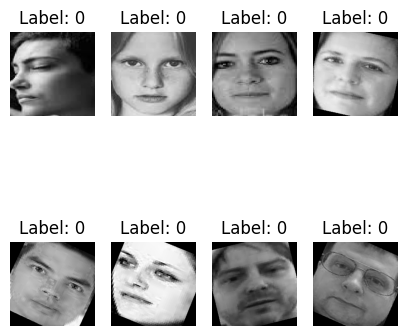

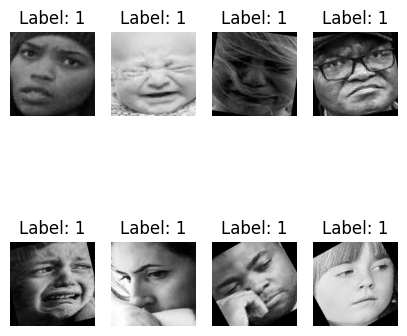

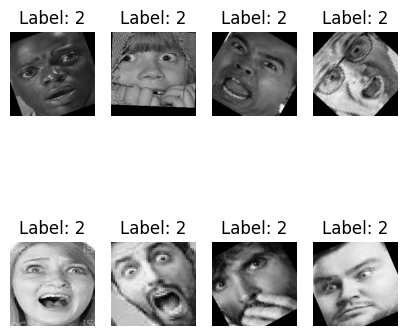

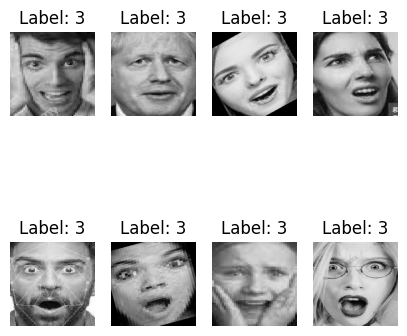

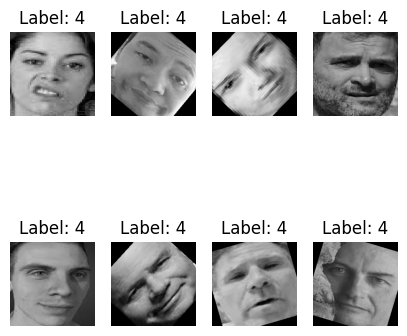

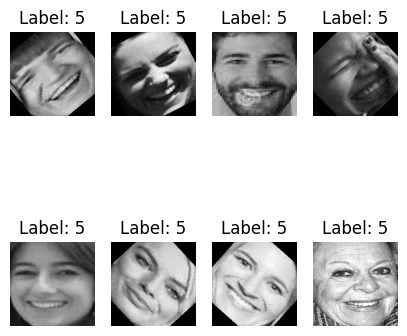

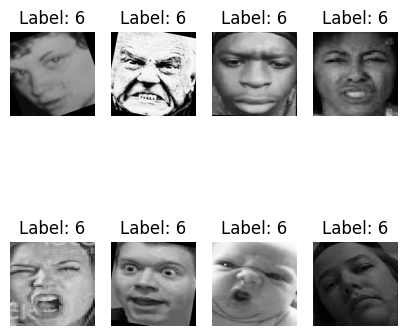

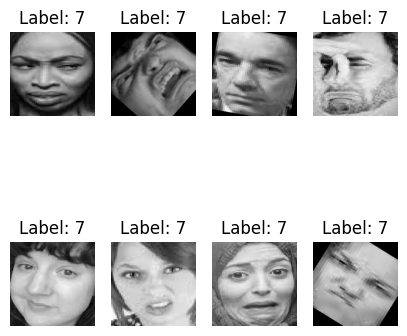

In [29]:
def show_images(images, labels):
    num_images = len(images)
    rows = int(np.sqrt(num_images))
    cols = int(np.ceil(num_images / rows))

    fig, axes = plt.subplots(rows, cols, figsize=(5, 5))

    for i, (image, label) in enumerate(zip(images, labels)):
        ax = axes.flatten()[i]
        ax.imshow(np.transpose(image, (1, 2, 0)))  # Swap axes for NumPy array
        ax.set_title(f"Label: {label}")
        ax.axis("off")

    plt.show()

# Iterate over the DataLoader
for label in range(len(classes)):  # Assuming 'classes' contains the class names
    # Filter images for the current label
    label_indices = [i for i, l in enumerate(labels) if l == label]

    # Randomly choose 5 images from the filtered indices
    chosen_indices = np.random.choice(label_indices, size=min(8, len(label_indices)), replace=False)

    # Extract images and labels for the chosen indices
    chosen_images = [features[i] for i in chosen_indices]
    chosen_labels = [labels[i] for i in chosen_indices]

    # Show images for the current label
    show_images(chosen_images, chosen_labels)

In [30]:

from torchvision import transforms
from collections import defaultdict

# Shuffle the labels and features in the same order
combined = list(zip(labels, features))
labels, features = zip(*combined)

# Create a dictionary to store images by label
label_to_images = defaultdict(list)

# Group images by label
for label, img in zip(labels, features):
    label_to_images[label].append(img)

# Set the ratios for train, validation, and test sets
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

train_data = []
validation_data = []
test_data = []

# Split data for each label
for label, images in label_to_images.items():
    random.shuffle(images)  # Shuffle the images for each label

    num_images = len(images)
    num_train = int(train_ratio * num_images)
    num_validation = int(validation_ratio * num_images)
    num_test = num_images - num_train - num_validation

    train_data.extend([(img, label) for img in images[:num_train]])
    validation_data.extend([(img, label) for img in images[num_train:num_train + num_validation]])
    test_data.extend([(img, label) for img in images[num_train + num_validation:]])

In [31]:

sample_index = 0  # Change this to the index of the sample you want to inspect

for i in range(15):
    sample_data, sample_label = test_data[i]
    print("Sample data shape:", sample_data.shape)

print("Sample label:", sample_label)
print(len(test_data))
print(len(validation_data))
print(len(train_data))
print(len(train_data))

Sample data shape: (3, 224, 224)
Sample data shape: (3, 224, 224)
Sample data shape: (3, 224, 224)
Sample data shape: (3, 224, 224)
Sample data shape: (3, 224, 224)
Sample data shape: (3, 224, 224)
Sample data shape: (3, 224, 224)
Sample data shape: (3, 224, 224)
Sample data shape: (3, 224, 224)
Sample data shape: (3, 224, 224)
Sample data shape: (3, 224, 224)
Sample data shape: (3, 224, 224)
Sample data shape: (3, 224, 224)
Sample data shape: (3, 224, 224)
Sample data shape: (3, 224, 224)
Sample label: 0
1676
1667
7793
7793


In [32]:

class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img, label = self.data[index]

        # Convert img to PyTorch tensor
        img_tensor = torch.tensor(img, dtype=torch.float32)

        return img_tensor, label

# Create datasets
train_dataset = CustomDataset(train_data)
validation_dataset = CustomDataset(validation_data)
test_dataset = CustomDataset(test_data)

# Create DataLoader instances
batch_size = 64  # You can adjust this based on your needs
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check the tensor size
for images, labels in train_loader:
    print(images.size())  # This will print the size of the tensor
    break


torch.Size([64, 3, 224, 224])


In [33]:
class CNNLargeNet(nn.Module):
    def __init__(self, output1, output2):
        super(CNNLargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, output1, 9)  # Adjust in_channels and kernel size
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(output1, output2, 9)  # Adjust in_channels
        self.fc1 = nn.Linear(output2 * 50 * 50, 128)  # Adjust input size
        self.fc2 = nn.Linear(128, 9)  # 9 output classes
        self.output2 = output2  # Store output2 as an attribute of the class

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.output2 * 50 * 50)  # Access output2 using self.output2
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [34]:
def get_accuracy(model, dataset):
    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(dataset, batch_size=64):
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

def trainmodel(model, train_dataset, val_dataset, batch=64, learningRate=0.001, num_epochs=10):
    # Create loss function and optimizer.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learningRate)
    # Load data
    train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=True)
    # Create accuracy lists
    iters, losses, train_accuracy, validation_accuracy = [], [], [], []
    n = 0  # Initialize the iteration counter
    # Train the data
    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch_data in train_loader:
            imgs, labels = batch_data
            img_to_tensor = transforms.ToTensor()
            imgs = img_to_tensor(image)
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()

            out = model(imgs)  # Forward pass
            loss = criterion(out, labels)  # Compute the total loss
            loss.backward()  # Backward pass (compute parameter updates)
            optimizer.step()  # Make the updates for each parameter
            optimizer.zero_grad()  # A clean-up step for PyTorch
            n += 1
            print("Input image data type:", imgs.dtype)
            print("Model parameters data types:")
            for param in model.parameters():
                print(param.dtype)
            # Save the current training information
            running_loss += loss.item()

        iters.append(n)
        losses.append(running_loss / len(train_loader))  # Compute average loss for the epoch
        train_accuracy.append(get_accuracy(model, train_dataset))  # Compute training accuracy

        # Compute validation accuracy for this epoch
        validation_accuracy.append(get_accuracy(model, val_dataset))  # Compute validation accuracy

        # Print progress for the epoch
        print("Epoch {}, Train Accuracy: {:.2f}%, Validation Accuracy: {:.2f}%".format(
            epoch, train_accuracy[epoch], validation_accuracy[epoch]))

        # Save model checkpoint
        model_checkpoint_path = '/content/gdrive/My Drive/ColabNotebooks/new'  # You can change the directory as needed
        model_checkpoint_file = os.path.join(model_checkpoint_path, f'{model.name} =Batch_size_{batch}_model_epoch{epoch + 1}.pth')
        torch.save(model.state_dict(), model_checkpoint_file)
        print(f"Saved model checkpoint: {model_checkpoint_file}")

    print("Finished Training")
    return iters, losses, train_accuracy, validation_accuracy

In [40]:
def trainSmall(model, data, batch_size=32, learning_rate=0.005, num_epochs=10):
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_acc = []

    # training
    print("Training Start")
    n = 0  # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            #############################################
            # To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()
            #############################################

            # Check if imgs is already a tensor
            if not torch.is_tensor(imgs):
                img_to_tensor = transforms.ToTensor()
                imgs = img_to_tensor(imgs)

                # Convert input to float
                imgs = imgs.float()

            # Convert the input tensor to the desired type
            imgs = imgs.type(torch.float32)

            out = model(imgs)  # forward pass
            loss = criterion(out, labels)  # compute the total loss
            loss.backward()  # backward pass (compute parameter updates)
            optimizer.step()  # make the updates for each parameter
            optimizer.zero_grad()  # a clean-up step for PyTorch
            n += 1

        train_accuracy = get_accuracy(model, data)
        train_acc.append(train_accuracy)
        print("Epoch:{}, Accuracy:{}".format(epoch, train_accuracy))
    return train_acc


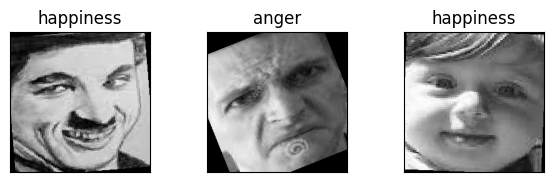

In [37]:
batch_size = 3
num_workers = 1
small_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

# Visualize some sample data
classes = ['neutrality', 'sadness', 'fear', 'surprise', 'contempt', 'happiness', 'anger', 'disgust']
dataiter = iter(small_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(3):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])

    # If the image has three channels
    if images[idx].shape[0] == 3:
        plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    else:  # If the image is grayscale
        plt.imshow(images[idx][0], cmap='gray')

    ax.set_title(classes[labels[idx]])

In [41]:
use_cuda = True
CNNmodel = CNNLargeNet(10,20)
Y = trainSmall(CNNmodel,test_data)

Training Start
Epoch:0, Accuracy:0.10202863961813842
Epoch:1, Accuracy:0.13424821002386636
Epoch:2, Accuracy:0.25238663484486873
Epoch:3, Accuracy:0.25238663484486873
Epoch:4, Accuracy:0.25238663484486873
Epoch:5, Accuracy:0.25238663484486873
Epoch:6, Accuracy:0.25238663484486873
Epoch:7, Accuracy:0.25238663484486873
Epoch:8, Accuracy:0.25238663484486873
Epoch:9, Accuracy:0.25238663484486873
